In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP

In [2]:
# Function to replace n/a in the data by the average of the data before and after the n/a
def fix_na(col):
    prev_is_na = False
    before = 0.0
    na_idxs = []
    for i in range(len(col)):
        val = str(col[i])
        if not prev_is_na and 'n/a' in val:
            prev_is_na = True
            before = col[i - 1]
            na_idxs.append(i)
        elif prev_is_na and 'n/a' in val:
            na_idxs.append(i)
        elif prev_is_na and 'n/a' not in val:
            col[i] = float(col[i])
            prev_is_na = False
            ave = (before + col[i]) / 2
            for j in na_idxs:
                col[j] = ave
            na_idxs = []
            before = 0.0
        else:
            col[i] = float(val)
    return col

In [3]:
# Read and clean the data from the Central Energy Plant
plant_data = pd.read_csv('Plant Steam Data.csv', nrows=9000)
plant_data.columns = ['date', 'time', 'pressure', 'steam flow', 'air temp', 'facility pressure']
all_dates = plant_data['date'].values
all_times = plant_data['time'].values
all_pressures = fix_na(plant_data['pressure'].values)
all_steam_flows = fix_na(plant_data['steam flow'].values)
all_air_temps = fix_na(plant_data['air temp'].values)
all_facility_pressures = fix_na(plant_data['facility pressure'].values)
months, days, years = [], [], []
for date in all_dates:
    #print(str(date))
    month, day, year = date.split('/')
    months.append(int(month))
    days.append(int(day))
    years.append(int(year))

hours = []
for time in all_times:
    number, period = time.split(' ')
    hour, minute, second = number.split(':')
    if period == 'PM':
        if hour != '12':
            hour = int(hour) + 12
    else:
        if hour == '12':
            hour = 0
    hours.append(int(hour))

# Create a new DataFrame with the cleaned up data
cleaned_plant_data = pd.DataFrame({
    'Month': months,
    'Day': days,
    'Year': years,
    'Hour': hours,
    'Pressure': all_pressures,
    'Steam Flow': all_steam_flows,
    'Air Temp': all_air_temps,
    'Facility Pressure': all_facility_pressures
})

# Read and clean the steam usage data
steam_usage = pd.read_csv('Steam Usage Year.csv')
steam_usage = steam_usage.drop(columns=['Unnamed: 2', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19'])
steam_usage = steam_usage.rename(columns={'Unnamed: 0': 'Building', 'Unnamed: 1': 'MeterNo'})
steam_usage = steam_usage.drop([0]).reset_index(drop=True)
data_months = ['Sep-24', 'Aug-24', 'Jul-24', 'Jun-24', 'May-24', 'Apr-24', 'Mar-24', 'Feb-24', 'Jan-24', 'Dec-23', 'Nov-23', 'Oct-23']
for month in data_months:
    data = steam_usage[month]
    for i in range(len(data)):
        data[i] = round(float(data[i]), 2)

In [4]:
# Show the first few rows of the plant data (steam flow is in lbs/hr)
cleaned_plant_data.head()

,Month,Day,Year,Hour,Pressure,Steam Flow,Air Temp,Facility Pressure
0,10,16,2024,7,88.45,23397.28,52.46,69.75
1,10,16,2024,6,90.40,18584.67,53.2,72.36
2,10,16,2024,5,90.74,17030.57,54.41,72.54
3,10,16,2024,4,90.78,15487.72,55.27,72.61
4,10,16,2024,3,90.79,15050.83,56.0,72.9


In [5]:
# Show the first few rows of the steam usage data (usage data is in lbs/month)
steam_usage.head()

,Building,MeterNo,Sep-24,Aug-24,Jul-24,Jun-24,May-24,Apr-24,Mar-24,Feb-24,Jan-24,Dec-23,Nov-23,Oct-23
0,Spectrum,7001,188349.63,175837.97,188216.35,201819.24,254298.24,420523.39,501457.67,670398.4,270591.72,262836.49,374283.56,336207.13
1,HPER,7002,496121.82,428632.85,301262.95,376176.62,551236.28,1241250.35,1754496.48,2184241.26,2533989.86,2360073.89,1954505.15,1633268.0
2,Family Life,7003,0.0,0.0,0.0,0.0,107670.0,196210.0,265330.0,254850.0,343760.0,323570.0,301520.0,194380.0
3,Maeser,7004,245638.0,217663.0,206800.0,222726.0,291209.0,381654.0,550546.0,623689.0,777253.0,730016.0,556323.0,361156.0
4,TSC,7006,764802.74,681889.39,834466.62,803301.2,981127.42,2019502.6,2320240.5,2786805.2,3174789.7,2987130.5,1362862.2,1107372.4


In [ ]:
# Grab the time data for the most recent full day
start_index = 8
end_index = start_index + 24
times = cleaned_plant_data['Hour'][start_index:end_index].values

# Grab the steam flow data for the most recent full day
steam_flows = cleaned_plant_data['Steam Flow'][start_index:end_index].values
m_dot_steam = []
for i in range(len(steam_flows)):
    m_dot_steam.append(round(steam_flows[i] / 2000, 3))

# Grab the outside air temperature data for the most recent full day
air_temps = cleaned_plant_data['Air Temp'][start_index:end_index].values

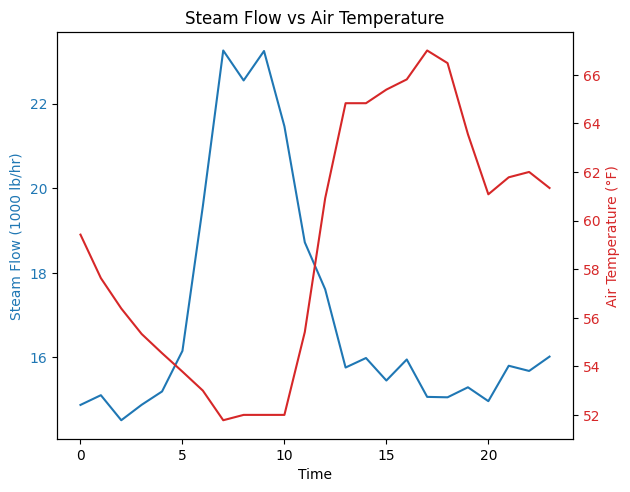

In [ ]:
# Plot steam flow and air temperature data for a full day
fig, ax1 = plt.subplots()

# Plot steam flow data
ax1.set_xlabel('Time')
ax1.set_ylabel('Steam Flow (tons/hr)', color='tab:blue')
ax1.plot(times, m_dot_steam, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot air temperature data
ax2 = ax1.twinx()
ax2.set_ylabel('Air Temperature (°F)', color='tab:red')
ax2.plot(times, air_temps, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Steam Flow vs Air Temperature')
plt.show()

In [8]:
# Compare total steam flow data between usage and production

# Sum all values in the 'Mar-24' column of the steam usage data
total_mar_24 = round(steam_usage['Mar-24'].sum(), 2)
print("Total Steam Used in March:", round(total_mar_24/2000,2), "tons")

# Calculate the total steam produced by the plant in March
month_vals = cleaned_plant_data['Month'].values
steam_flow_vals = cleaned_plant_data['Steam Flow'].values
total_steam = 0
for i in range(len(month_vals)):
    if month_vals[i] == 3:
        total_steam += steam_flow_vals[i]
total_steam = round(total_steam, 2)
print("Total Steam Produced in March:", round(total_steam/2000,2), "tons")

# Calculate the difference between the total steam used and the total steam produced
diff = total_steam - total_mar_24
print("Difference in Steam Used and Steam Produced:", round(diff/2000,2), "tons")
print("Percent Difference:", round((diff / total_steam) * 100, 2), "%")

Total Steam Used in March: 11763.59 tons
Total Steam Produced in March: 13048.17 tons
Difference in Steam Used and Steam Produced: 1284.57 tons
Percent Difference: 9.84 %


In [9]:
# Placeholder values for enthalpy in and out
enthalpy_ss_90 = 2764.04
enthalpy_sw_atm = 418.99

# Calculate the heat transferred to a building
def heat_transferred(m_dot, h1, h2):
    return round(m_dot * (h2 - h1), 2)

Total Steam Flow in March
Spectrum: 250.73 tons
HPER: 877.25 tons
Family Life: 132.66 tons
Maeser: 275.27 tons
TSC: 1160.12 tons
FieldHouse: 68.0 tons
Ind Science: 140.9 tons
ECC: 52.16 tons
INN: 113.5 tons
Facilities: 88.12 tons
NFS: 269.39 tons
Business: 189.39 tons
BNR: 455.99 tons
NR: 57.1 tons
HSRC: 67.45 tons
Eng New: 138.27 tons
Eng lab: 409.65 tons
Merrill: 107.15 tons
FA Center: 275.89 tons
FA Museum: 76.02 tons
LLC: 298.64 tons
FA Visual: 288.76 tons
Richards: 158.37 tons
SER: 177.71 tons
Junction: 312.74 tons
Bullen: 67.68 tons
Old Main: 300.85 tons
Forage Range: 397.63 tons
Geology: 195.28 tons
Ray B West: 149.69 tons
Biotech: 221.41 tons
Education: 116.56 tons
Sci Tech Lib: 163.33 tons
Widtsoe: 413.67 tons
Edith Bowen: 150.54 tons
Forestry Science: 30.61 tons
Uni Reserve: 38.43 tons
Alumni: 26.3 tons
Quinney Lawson: 61.29 tons
Perf Hall: 48.39 tons
MC Lib: 152.83 tons
Eng Sant: 111.12 tons
Vet Science: 549.26 tons
Lillywhite: 23.39 tons
Early Childhood: 128.13 tons
Technol

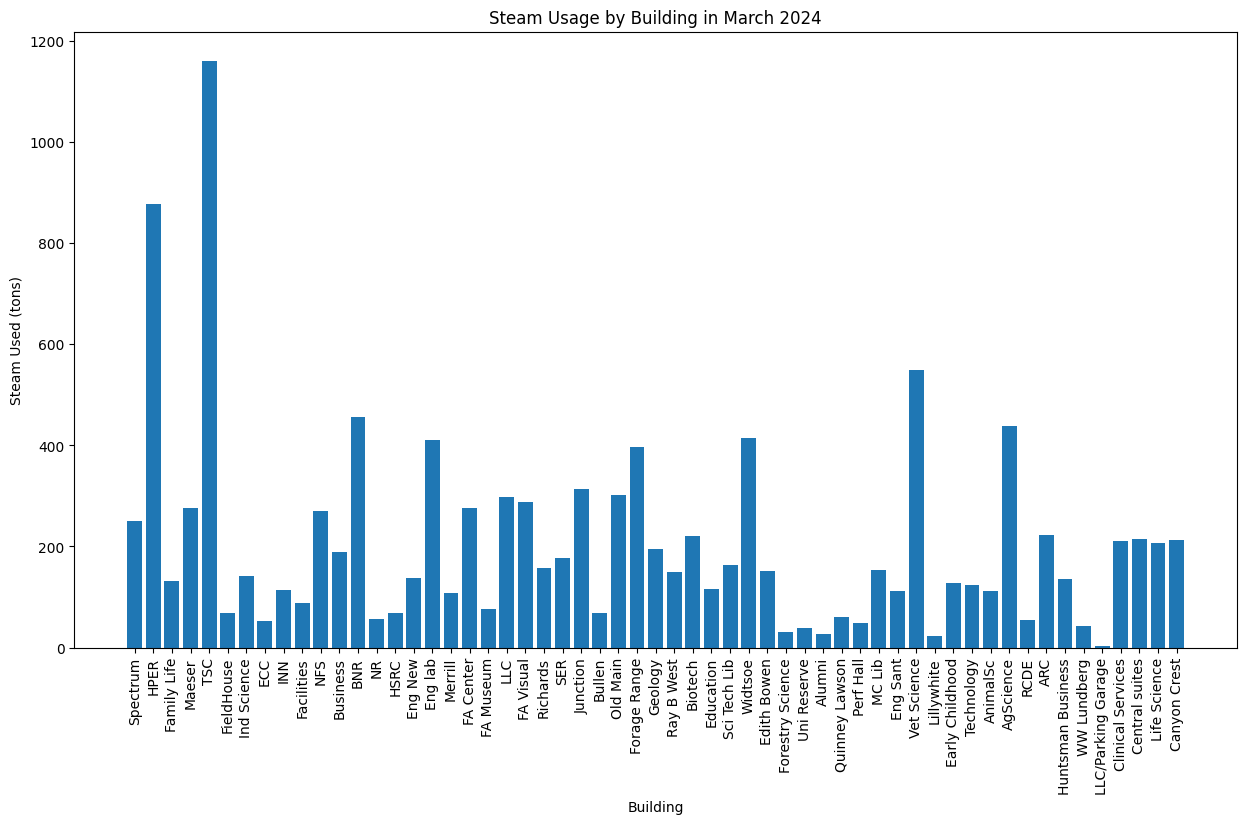

In [10]:
# Plot heat transferred to each building in a given month
month = 'Mar-24'
month_name = 'March'
monthly_steam = steam_usage[f'{month}'].values
buildings = steam_usage['Building'].values

# Print the results for all buildings
print(f"Total Steam Flow in {month_name}")
for i in range(len(buildings)):
    print(buildings[i] + ': ' + str(round(monthly_steam[i]/2000, 2)) + ' tons')

# Display the plot
plt.figure(figsize=(15, 8))
plt.bar(buildings, [steam / 2000 for steam in monthly_steam])
plt.xlabel('Building')
plt.ylabel('Steam Used (tons)')
plt.title(f'Steam Usage by Building in {month_name} 2024')
plt.xticks(rotation=90)
plt.show()

In [11]:
# Get steam usage ratios
steam_usage_ratios = []
months = ['Sep-24', 'Aug-24', 'Jul-24', 'Jun-24', 'May-24', 'Apr-24', 'Mar-24', 'Feb-24', 'Jan-24', 'Dec-23', 'Nov-23', 'Oct-23']
month_nums = [9, 8, 7, 6, 5, 4, 3, 2, 1, 12, 11, 10]
for month in months:
    monthly_ratio = []
    steam_data = steam_usage[month].values
    total_steam = sum(steam_data)
    for valve in steam_data:
        monthly_ratio.append(valve / total_steam)
    steam_usage_ratios.append(monthly_ratio)

transposed_usage = np.transpose(steam_usage)
transposed_ratios = np.transpose(steam_usage_ratios)
df_ratios = pd.DataFrame(transposed_ratios, columns=month_nums, index=buildings)
df_ratios.head(57)

,9,8,7,6,5,4,3,2,1,12,11,10
Spectrum,0.020463,0.021885,0.026038,0.025033,0.024279,0.024873,0.021314,0.025212,0.008587,0.008727,0.015853,0.019913
HPER,0.053899,0.053348,0.041677,0.046660,0.052630,0.073416,0.074573,0.082145,0.080417,0.078364,0.082782,0.096736
Family Life,0.000000,0.000000,0.000000,0.000000,0.010280,0.011605,0.011278,0.009584,0.010909,0.010744,0.012771,0.011513
Maeser,0.026686,0.027091,0.028609,0.027626,0.027803,0.022574,0.023400,0.023456,0.024666,0.024239,0.023563,0.021391
TSC,0.083089,0.084869,0.115441,0.099639,0.093674,0.119448,0.098620,0.104806,0.100752,0.099184,0.057723,0.065588
FieldHouse,0.017380,0.019672,0.029325,0.008279,0.000963,0.003209,0.005780,0.004973,0.007510,0.006582,0.020478,0.016796
Ind Science,0.008552,0.014191,0.014794,0.020277,0.016720,0.012883,0.011978,0.011235,0.011868,0.010105,0.011754,0.004660
ECC,0.005676,0.002790,0.002340,0.002667,0.005155,0.005703,0.004434,0.005729,0.004752,0.004886,0.004768,0.004358
INN,0.019120,0.019560,0.020658,0.018346,0.014082,0.011213,0.009648,0.008546,0.008917,0.011256,0.009039,0.014402
Facilities,0.004038,0.007239,0.008335,0.007308,0.008394,0.007778,0.007491,0.006913,0.006503,0.006051,0.006109,0.008420


In [12]:
# Add a column to the DataFrame for the distance from the Central Energy Plant to each building
distances = [0.109, 0.303, 0.888, 0.573, 0.504, 0.44, 0.52, 0.509, 0.444, 1, 0.985, 0.636, 0.417, 0.49, 0.508, 0.721, 0.725, 0.75, 0.746, 0.667, 0.625, 0.72, 0.473, 0.78, 0.492, 0.564, 0.691, 0.758, 0.508, 0.701, 0.485, 0.327, 0.568, 0.587, 0.392, 0.795, 0.663, 0.354, 0.445, 0.648, 0.589, 0.782, 0.35, 0.47, 0.261, 0.549, 0.606, 0.563, 0.502, 0.377, 0.621, 0.735, 0.697, 0.373, 0.517, 0.453, 0.585]
df_ratios['Distance'] = distances
df_ratios.head()

,9,8,7,6,5,4,3,2,1,12,11,10,Distance
Spectrum,0.020463,0.021885,0.026038,0.025033,0.024279,0.024873,0.021314,0.025212,0.008587,0.008727,0.015853,0.019913,0.109
HPER,0.053899,0.053348,0.041677,0.046660,0.052630,0.073416,0.074573,0.082145,0.080417,0.078364,0.082782,0.096736,0.303
Family Life,0.000000,0.000000,0.000000,0.000000,0.010280,0.011605,0.011278,0.009584,0.010909,0.010744,0.012771,0.011513,0.888
Maeser,0.026686,0.027091,0.028609,0.027626,0.027803,0.022574,0.023400,0.023456,0.024666,0.024239,0.023563,0.021391,0.573
TSC,0.083089,0.084869,0.115441,0.099639,0.093674,0.119448,0.098620,0.104806,0.100752,0.099184,0.057723,0.065588,0.504


/var/folders/qz/7htjwjyd7jl80166y4m1gjcr0000gn/T/ipykernel_35246/510714926.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  usage_plots[j].append(transposed_usage[plot_indexes[j]][i+2])


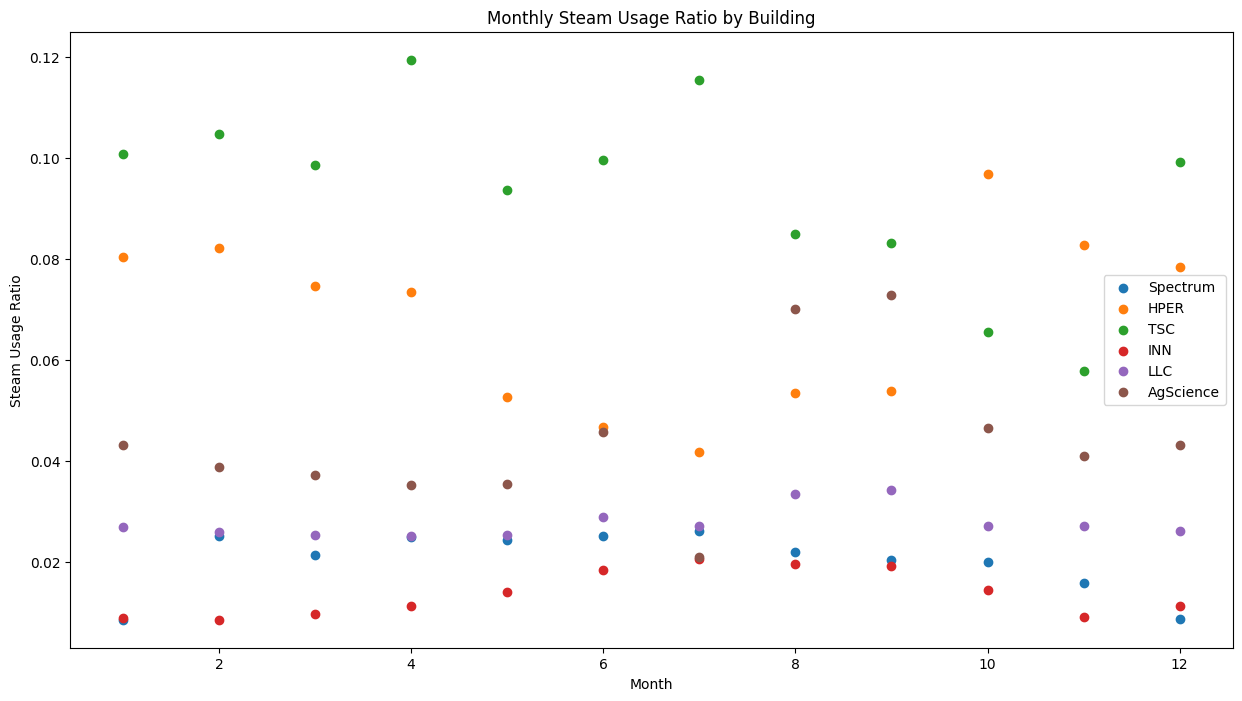

In [13]:
# Plot the steam usage ratios for each building
plot_indexes = [0, 1, 4, 8, 20, 47]
plots = []
usage_plots = []
plot_months = []
for index in plot_indexes:
    plots.append([])
    usage_plots.append([])
for i in range(len(month_nums)):
    for j in range(len(plot_indexes)):
        plots[j].append(transposed_ratios[plot_indexes[j]][i])
        usage_plots[j].append(transposed_usage[plot_indexes[j]][i+2])
for i in range(len(plot_indexes)):
    plot_months.append(buildings[plot_indexes[i]])
plt.figure(figsize=(15, 8))
for r in plots:
    plt.scatter(month_nums, r)
plt.xlabel('Month')
plt.ylabel('Steam Usage Ratio')
plt.title('Monthly Steam Usage Ratio by Building')
plt.legend(plot_months)
plt.show()

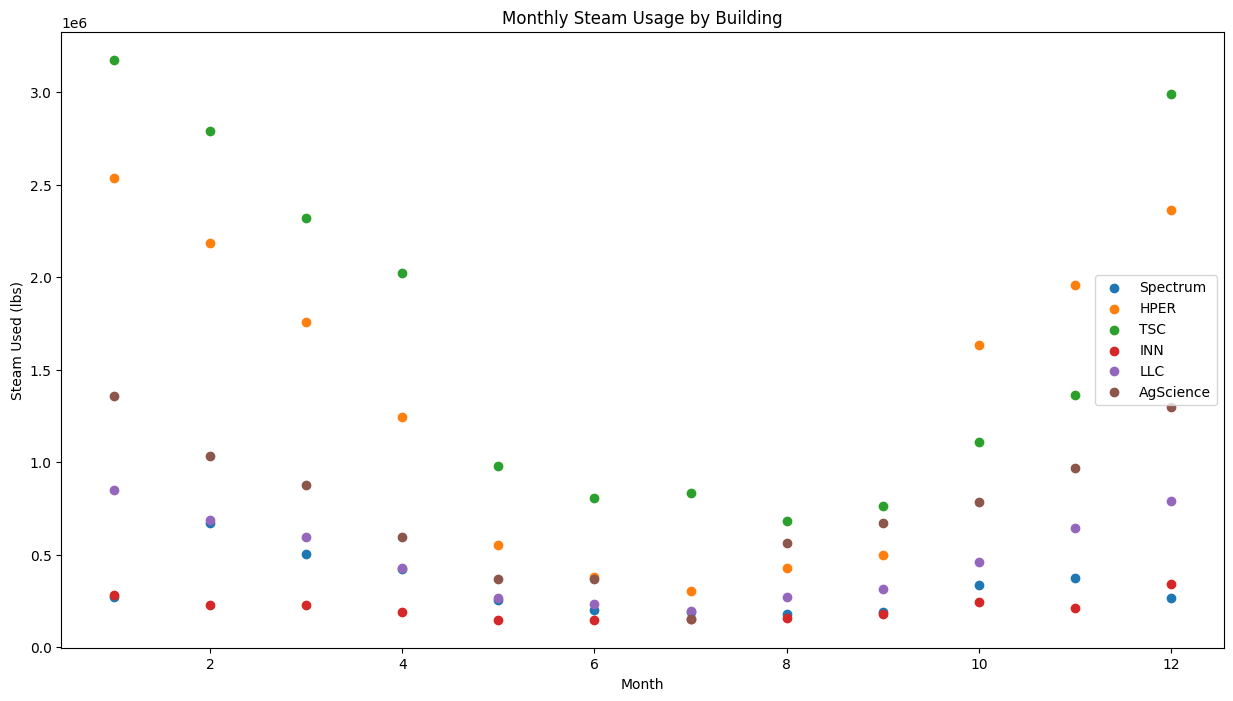

In [14]:
plt.figure(figsize=(15, 8))
for r in usage_plots:
    plt.scatter(month_nums, r)
plt.xlabel('Month')
plt.ylabel('Steam Used (lbs)')
plt.title('Monthly Steam Usage by Building')
plt.legend(plot_months)
plt.show()

In [15]:
# Functions for entropy calculations
def specific_entropy(P, Q, fluid='Water'):
    # Returns specific entropy in J/kg-K based on pressure and quality
    return CP.PropsSI('S', 'P', P, 'Q', Q, fluid)

def specific_enthalpy(P, Q, fluid='Water'):
    # Returns specific enthalpy in J/kg based on pressure and quality
    return CP.PropsSI('H', 'P', P, 'Q', Q, fluid)

def psi_to_pa(psi):
    # Assumes an atmospheric pressure in Logan of 85500 Pa
    return psi * 6894.76 + 85500

def entropy_generation(m_dot_tunnel, s_1_tunnel, s_2_tunnel, h_1_tunnel, h_2_tunnel):
    # Calculate the entropy generation in the tunnel
    delta_h_tunnel = h_1_tunnel - h_2_tunnel
    p_build = psi_to_pa(15)
    delta_h_build = specific_enthalpy(p_build, 1) - specific_enthalpy(p_build, 0)
    m_dot_build = m_dot_tunnel * (delta_h_tunnel / delta_h_build)
    return m_dot_tunnel * (s_2_tunnel - s_1_tunnel) + m_dot_build * (specific_entropy(p_build, 1) - specific_entropy(p_build, 0))

def get_building_data(index):
    month, total_flow, plant_pressure, air_temp, fac_pressure = cleaned_plant_data['Month'][index], cleaned_plant_data['Steam Flow'][index], cleaned_plant_data['Pressure'][index], cleaned_plant_data['Air Temp'][index], cleaned_plant_data['Facility Pressure'][index]
    day, hour = cleaned_plant_data['Day'][index], cleaned_plant_data['Hour'][index]
    timestamp = f"{month}/{day} {hour}:00"
    p_drop = plant_pressure - fac_pressure
    building_pressure, building_steam = [], []
    p_drops, p_abs = [], []
    entrance_enthalpy, exit_enthalpy, entrance_entropy, exit_entropy = [], [], [], []
    month_ratio = df_ratios[month].values
    build_dists = df_ratios['Distance'].values
    building_names = df_ratios.index.tolist()
    heat_transfer = []
    s_gen = []
    Q_max = total_flow * (specific_enthalpy(psi_to_pa(plant_pressure), 1) - specific_enthalpy(psi_to_pa(0), 0))
    Q_actual = 0
    S_gen_buildings = 0
    for i in range(len(build_dists)):
        # Calculate the pressure drop and absolute pressure for each building
        p_drop_build = month_ratio[i] * p_drop
        p_building = psi_to_pa(plant_pressure - p_drop_build)
        p_drops.append(p_drop_build)
        p_abs.append(p_building)

        # Calculate the steam flow for each building as well as enthalpy and entropy values
        steam_building = total_flow * month_ratio[i]
        enthalpy_entr = specific_enthalpy(p_building, 1)
        enthalpy_exit = specific_enthalpy(p_building, 0)
        entropy_entr = specific_entropy(p_building, 1)
        entropy_exit = specific_entropy(p_building, 0)
        entrance_enthalpy.append(enthalpy_entr)
        exit_enthalpy.append(enthalpy_exit)
        entrance_entropy.append(entropy_entr)
        exit_entropy.append(entropy_exit)
        heat_transferred = steam_building * (enthalpy_entr - enthalpy_exit)
        heat_transfer.append(heat_transferred)
        Q_actual += heat_transferred
        entropy_generated = entropy_generation(steam_building, entropy_entr, entropy_exit, enthalpy_entr, enthalpy_exit)
        s_gen.append(entropy_generated)
        S_gen_buildings += entropy_generated

        # Append the building pressure and steam flow to the lists
        building_pressure.append(p_building)
        building_steam.append(steam_building)
    data = {
        "Building": building_names,
        "Steam Flow (lb/hr)": building_steam,
        "Ratio": month_ratio,
        "Distance (mi)": build_dists,
        "Pressure Drop (psi)": p_drops,
        "Absolute Pressure (Pa)": p_abs,
        "h1 (J/kg)": entrance_enthalpy,
        "h2 (J/kg)": exit_enthalpy,
        "s1 (J/kg-K)": entrance_entropy,
        "s2 (J/kg-K)": exit_entropy,
        "Q (J)": heat_transfer,
        "S_gen (J/K)": s_gen
    }
    Q_loss = Q_max - Q_actual
    S_gen_tunnels = Q_loss/air_temp
    S_gen = S_gen_tunnels + S_gen_buildings
    index_df = pd.DataFrame(data)
    return index_df, air_temp, Q_loss, S_gen, S_gen_tunnels, timestamp

In [18]:
# Test
index_df_12, tunnel_temp, heat_loss, entropy_generated, tunnel_entropy, time = get_building_data(12)

print(f"Results at {time}")
print("Total Heat Loss:", round(heat_loss/1000, 2), "kJ")
print("Total Entropy Generated:", round(entropy_generated/1000, 2), "kJ/K")
print("Entropy Generated in Tunnels:", round(tunnel_entropy/1000, 2), "kJ/K")

Results at 10/15 19:00
Total Heat Loss: 4584557.66 kJ
Total Entropy Generated: 80771.76 kJ/K
Entropy Generated in Tunnels: 72140.95 kJ/K


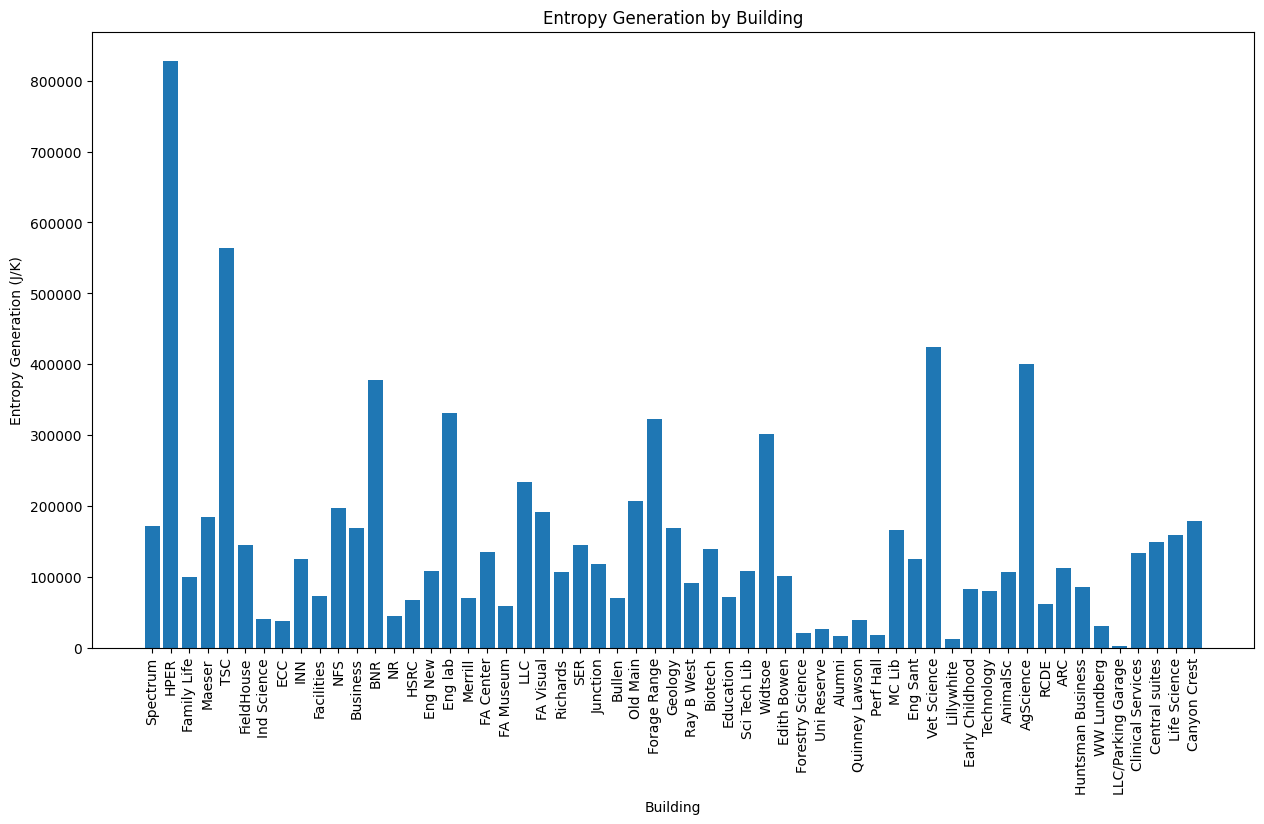

In [22]:
# Add tunnel entropy to the dataframe
bldgs = index_df_12['Building'].tolist()
sgens = index_df_12['S_gen (J/K)'].tolist()

# Plot the entropy generation for each building including the tunnel
plt.figure(figsize=(15, 8))
plt.bar(bldgs, sgens)
plt.xlabel('Building')
plt.ylabel('Entropy Generation (J/K)')
plt.title('Entropy Generation by Building')
plt.xticks(rotation=90)
plt.show()

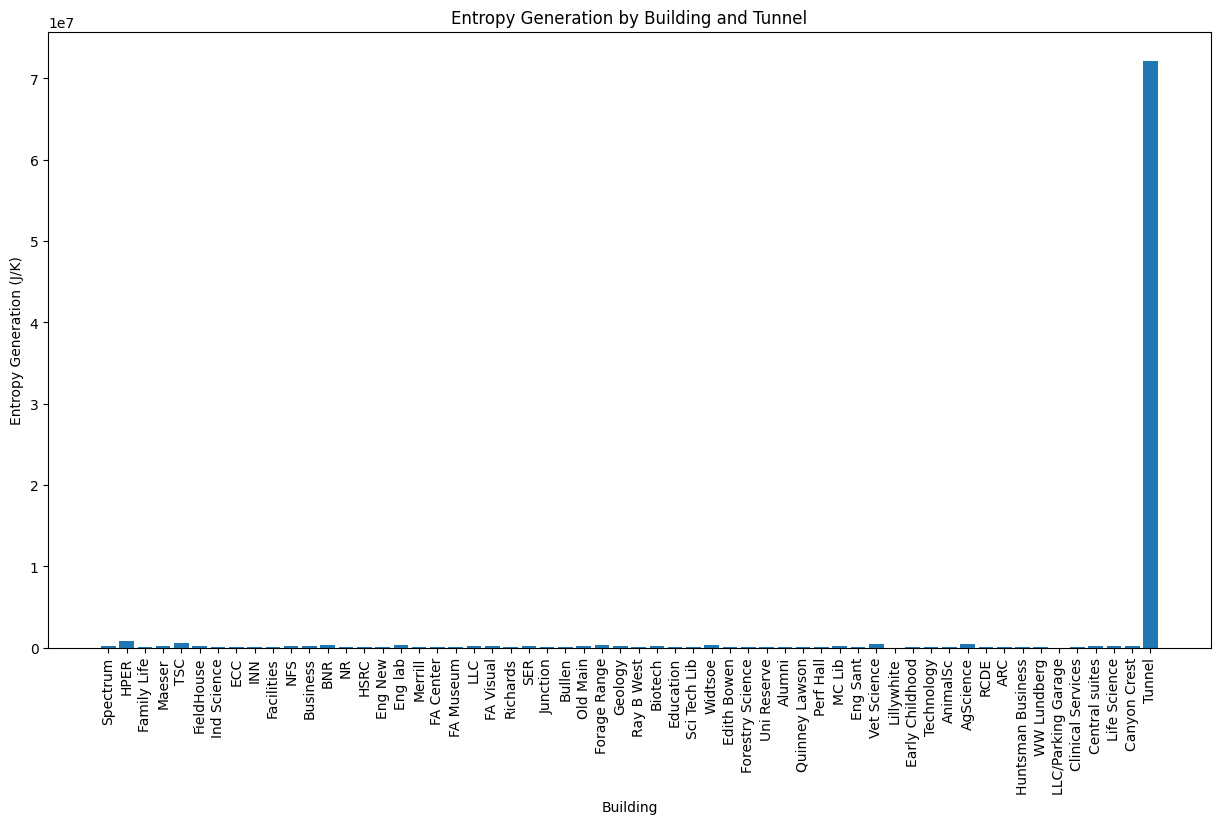

In [20]:
# Add tunnel entropy to the dataframe
bldgs = index_df_12['Building'].tolist()
sgens = index_df_12['S_gen (J/K)'].tolist()
bldgs.append('Tunnel')
sgens.append(tunnel_entropy)

# Plot the entropy generation for each building including the tunnel
plt.figure(figsize=(15, 8))
plt.bar(bldgs, sgens)
plt.xlabel('Building')
plt.ylabel('Entropy Generation (J/K)')
plt.title('Entropy Generation by Building and Tunnel')
plt.xticks(rotation=90)
plt.show()

In [17]:
index_df_12.head(60)

,Building,Steam Flow (lb/hr),Ratio,Distance (mi),Pressure Drop (psi),Absolute Pressure (Pa),h1 (J/kg),h2 (J/kg),s1 (J/kg-K),s2 (J/kg-K),Q (J),S_gen (J/K)
0,Spectrum,304.555086,0.019913,0.109,0.380936,708917.747078,2.763287e+06,699231.439447,6702.765511,1996.836780,6.286185e+08,172173.346646
1,HPER,1479.504842,0.096736,0.303,1.850556,698785.065807,2.762679e+06,696696.357270,6707.653511,1991.078723,3.056632e+09,827938.237245
2,Family Life,176.080197,0.011513,0.888,0.220240,710025.705183,2.763352e+06,699506.958543,6702.235112,1997.462103,3.634023e+08,99652.136146
3,Maeser,327.155158,0.021391,0.573,0.409204,708722.845702,2.763275e+06,699182.938815,6702.858896,1996.726693,6.752784e+08,184914.068530
4,TSC,1003.119407,0.065588,0.504,1.254696,702893.379163,2.762927e+06,697727.568862,6705.663499,1993.421922,2.071642e+09,563689.511565
5,FieldHouse,256.875254,0.016796,0.440,0.321298,709328.934486,2.763311e+06,699333.728878,6702.568575,1997.068949,5.301847e+08,145277.768394
6,Ind Science,71.272885,0.004660,0.520,0.089148,710929.555823,2.763406e+06,699731.478981,6701.803013,1997.971609,1.470840e+08,40372.696197
7,ECC,66.653203,0.004358,0.509,0.083369,710969.395625,2.763408e+06,699741.370352,6701.783979,1997.994054,1.375500e+08,37757.348659
8,INN,220.265058,0.014402,0.444,0.275506,709644.658157,2.763330e+06,699412.239500,6702.417436,1997.247137,4.546089e+08,124611.505624
9,Facilities,128.777309,0.008420,1.000,0.161074,710433.641848,2.763377e+06,699608.318752,6702.040027,1997.692128,2.657665e+08,72910.548617
